<a href="https://colab.research.google.com/github/lilianagalli/itba2/blob/main/itba2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🔎 Resumen posición por posición (Alice ⟶ Eve ⟶ Bob)

,pos,Alice_bit,Alice_base,Eve_base,Eve_bit,Bob_base,Bob_bit,Bases_Alice==Bob
0,0,1,Z,Z,1,Z,1,True
1,1,0,X,Z,0,X,0,True
2,2,1,Z,Z,1,Z,1,True
3,3,1,X,Z,1,Z,1,False
4,4,0,X,X,0,Z,0,False
5,5,0,Z,Z,0,X,0,False
6,6,1,Z,X,1,Z,1,True
7,7,0,X,X,0,Z,1,False
8,8,1,Z,X,0,Z,1,True
9,9,0,X,Z,1,X,0,True


### 🟦 Visualización en la esfera de Bloch (Alice → después de Eve reedificado)

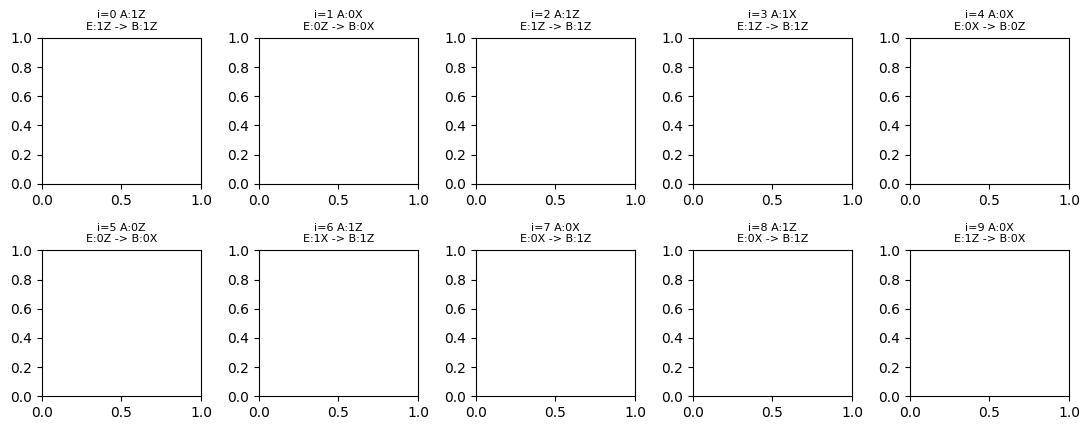

### 🔁 Comparación: estado original de Alice vs estado que Eve reenvía

**Posición 0** — Alice: bit=1 base=Z  |  Eve midió: bit=1 base=Z

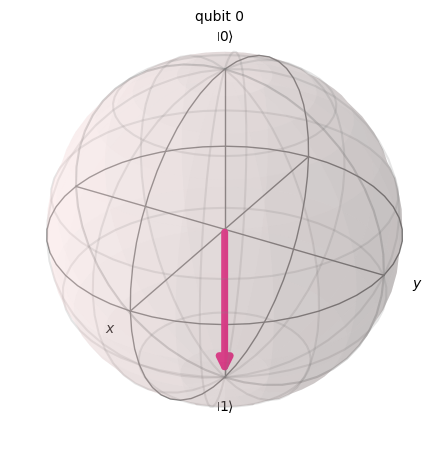

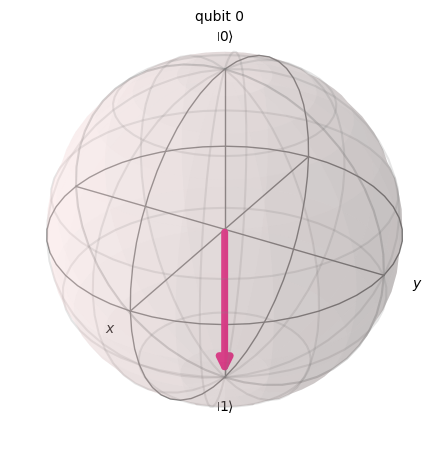

**Posición 1** — Alice: bit=0 base=X  |  Eve midió: bit=0 base=Z

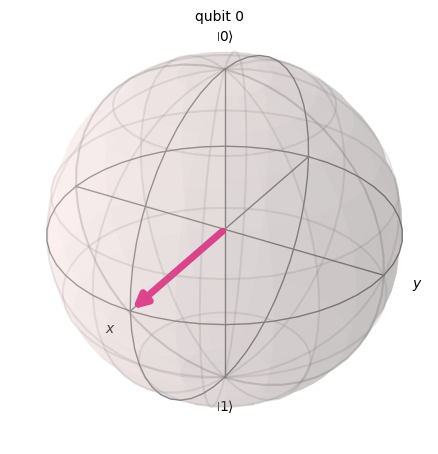

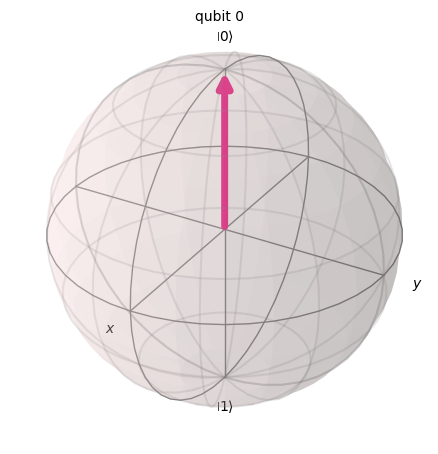

**Posición 2** — Alice: bit=1 base=Z  |  Eve midió: bit=1 base=Z

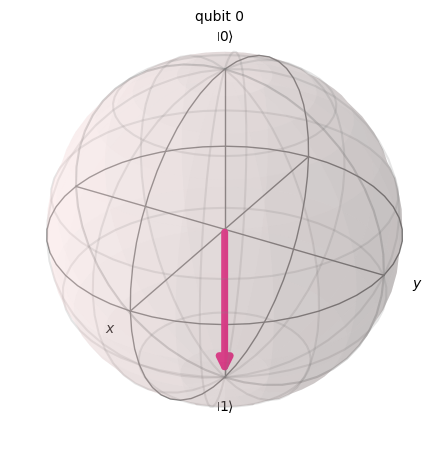

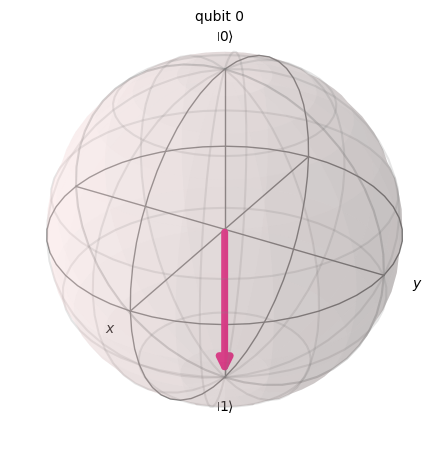

**Posición 3** — Alice: bit=1 base=X  |  Eve midió: bit=1 base=Z

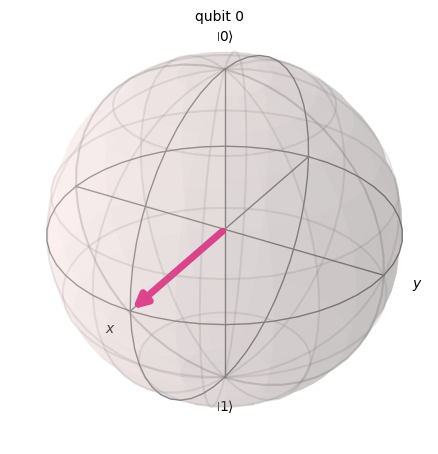

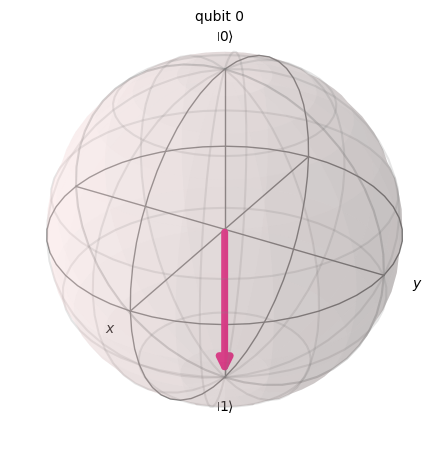

**Posición 4** — Alice: bit=0 base=X  |  Eve midió: bit=0 base=X

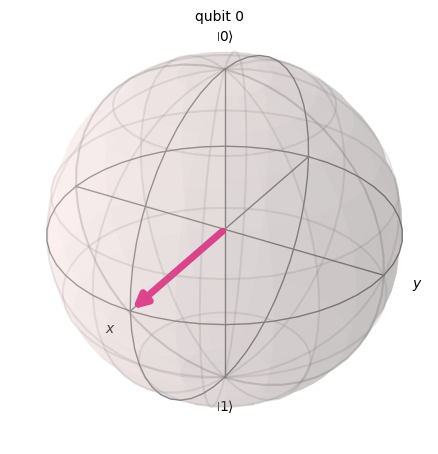

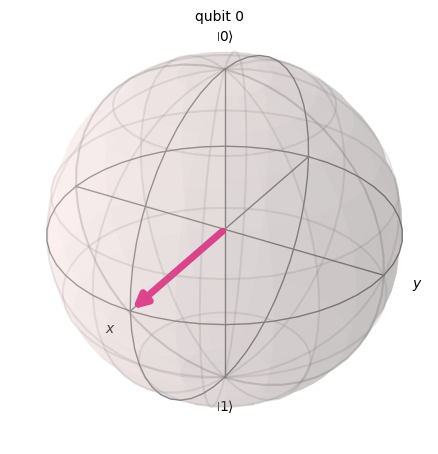

**Posición 5** — Alice: bit=0 base=Z  |  Eve midió: bit=0 base=Z

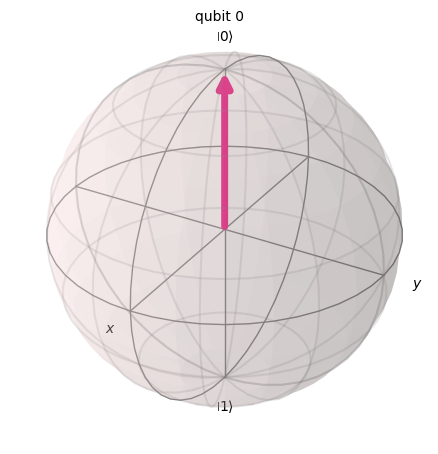

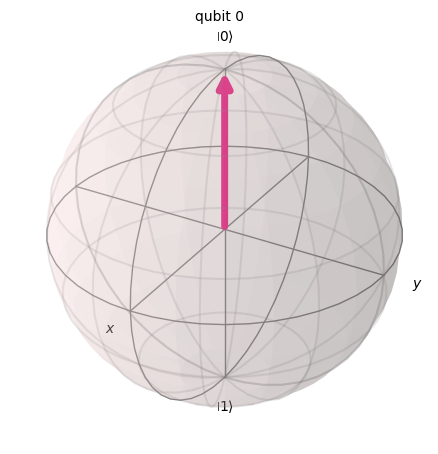

**Posición 6** — Alice: bit=1 base=Z  |  Eve midió: bit=1 base=X

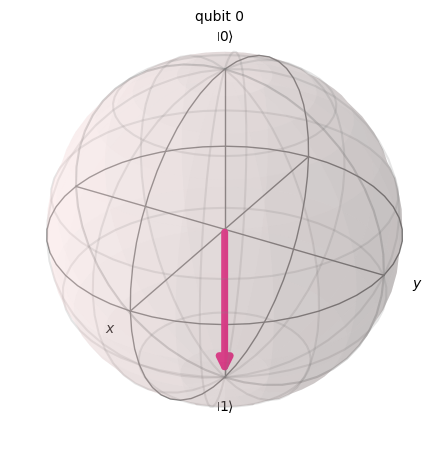

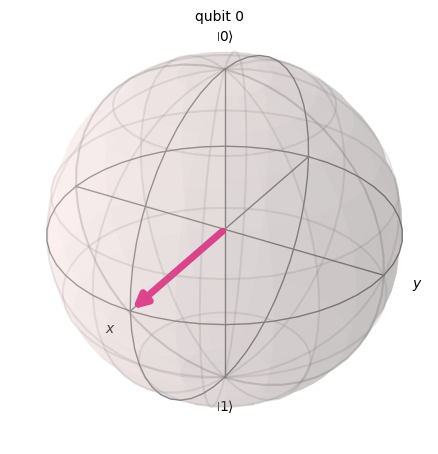

**Posición 7** — Alice: bit=0 base=X  |  Eve midió: bit=0 base=X

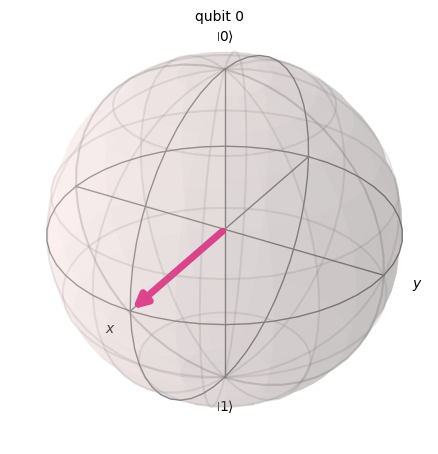

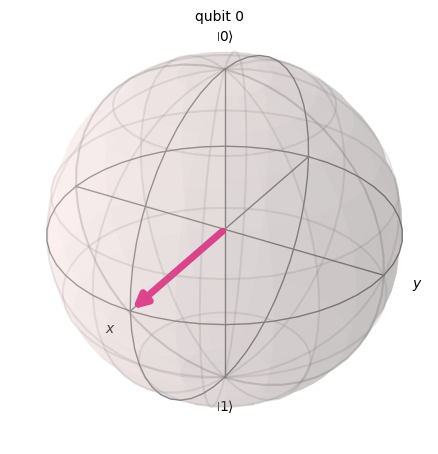

**Posición 8** — Alice: bit=1 base=Z  |  Eve midió: bit=0 base=X

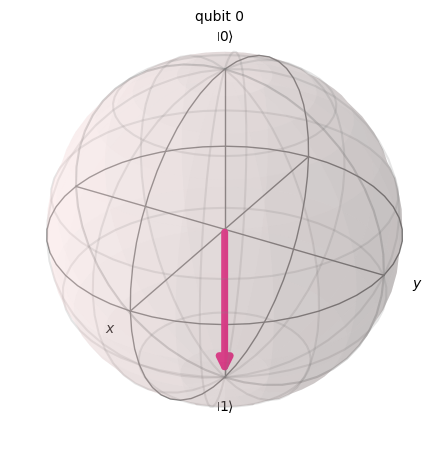

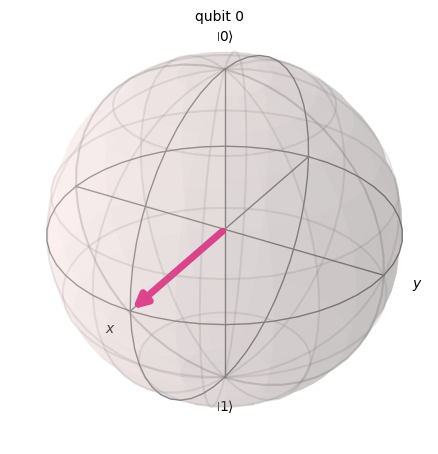

**Posición 9** — Alice: bit=0 base=X  |  Eve midió: bit=1 base=Z

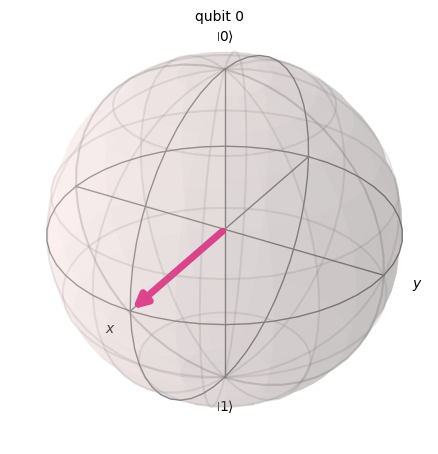

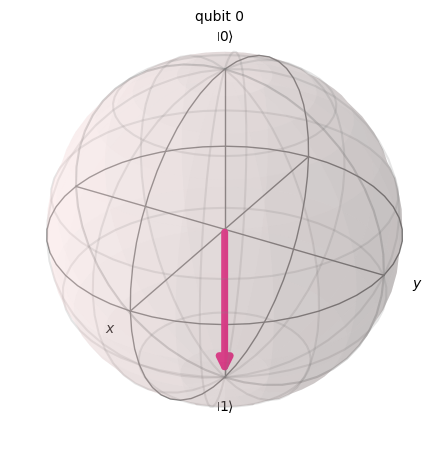

### 📈 Comparación de bits (Alice vs Bob tras ataque de Eve)

TypeError: only integer scalar arrays can be converted to a scalar index

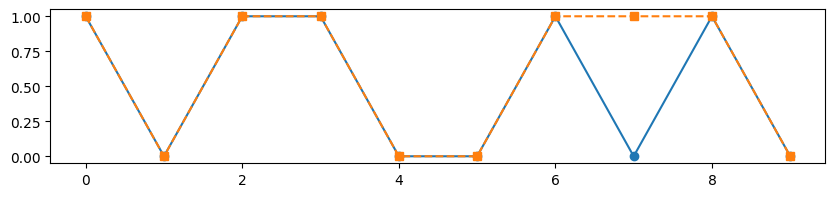

In [3]:
# ==========================================
# BB84 con Eve espiando — visualización completa
# Compatible con Qiskit 1.x en Google Colab
# ==========================================
!pip install -q qiskit qiskit-aer qiskit[visualization] matplotlib numpy pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

# -------------------------
# Parámetros / ejemplo fijo
# -------------------------
# Usamos el ejemplo que diste para Alice:
# "String de Alice 1011001010"
alice_bits = np.array([1,0,1,1,0,0,1,0,1,0], dtype=int)
# Bases de Alice según tu tabla (Z=0, X=1)
alice_bases = np.array([0,1,0,1,1,0,0,1,0,1], dtype=int)  # Z,X,Z,X,X,Z,Z,X,Z,X

n = len(alice_bits)
np.random.seed(42)

# Bob elige bases aleatorias
bob_bases = np.random.randint(0,2,size=n)
# Eve decide espiar: elegimos sus bases aleatoriamente (podés cambiar a deterministic si querés)
eve_bases = np.random.randint(0,2,size=n)

# Backends
sim_state = Aer.get_backend('aer_simulator_statevector')
sim_qasm  = Aer.get_backend('aer_simulator')  # para mediciones (shots=1)

# -------------------------
# Funciones auxiliares
# -------------------------
def prepare_qubit_circuit(bit, base):
    """Prepara circuito (sin medidas) representando el qubit que Alice envía."""
    qc = QuantumCircuit(1)
    if base == 0:  # Z
        if bit == 1:
            qc.x(0)
    else:  # X
        # |+> corresponds to H|0>; |-> = H|1> (we implement via X then H or H then Z trick)
        if bit == 1:
            # prepare |-> : X then H then Z? simpler: prepare |1> then H then Z -> but we'll use X then H then Z
            qc.x(0)
            qc.h(0)
            qc.z(0)
        else:
            qc.h(0)
    return qc

def measure_in_basis(qc_in, measure_basis):
    """
    Toma un QuantumCircuit (1 qubit) sin medición, aplica rotación para medir en la base deseada,
    hace measure y devuelve bit medido (0/1).
    """
    qc = qc_in.copy()
    # añadir registro clásico para medición
    qc.measure_all()
    if measure_basis == 1:
        # medir en X -> aplicar H before measurement (but we inserted measurement already)
        # Instead build qc: apply H then measure; so we must build qc appropriately.
        # To be safe, rebuild qc as: original ops -> H -> measure
        # We'll reconstruct: take statevector and measure in X by applying H before measuring.
        pass
    # transpile + run
    # Note: Qiskit requires H before measure if wanting X basis; but we will instead create explicit qc:
    return None  # never used; we use explicit circuits later

# -------------------------
# Simulación: Alice -> Eve -> Bob
# -------------------------
# guardamos info en listas para visualizar después
eve_results = []
bob_results = []
alice_to_bob_circuits = []  # qubits que Eve reenvía (as circuits)

for i in range(n):
    # Alice prepara
    qc_alice = prepare_qubit_circuit(alice_bits[i], alice_bases[i])
    # --- Visual (opcional): estado antes de Eve si queremos más adelante ---
    # Eve intercepta: mide en su base
    # Para medir en Z: simplemente measure. For X: apply H then measure.
    qc_eve = qc_alice.copy()
    if eve_bases[i] == 1:
        qc_eve.h(0)
    # add classical and measure
    qc_eve.measure_all()
    compiled = transpile(qc_eve, sim_qasm)
    res = sim_qasm.run(compiled, shots=1).result()
    eve_bit = int(list(res.get_counts().keys())[0])
    eve_results.append(eve_bit)

    # Eve re-prepara (reconstituye) un qubit acorde a lo que midió, en la base que midió.
    # Si Eve midió bit b in base B, then she will prepare prepared_qubit(b, B).
    qc_reemit = prepare_qubit_circuit(eve_bit, eve_bases[i])
    alice_to_bob_circuits.append(qc_reemit)

# Ahora Bob mide cada circuito recibido de Eve
for i in range(n):
    qc = alice_to_bob_circuits[i].copy()
    # If Bob measures in X basis, apply H before measuring
    if bob_bases[i] == 1:
        qc.h(0)
    qc.measure_all()
    compiled = transpile(qc, sim_qasm)
    res = sim_qasm.run(compiled, shots=1).result()
    bob_bit = int(list(res.get_counts().keys())[0])
    bob_results.append(bob_bit)

# -------------------------
# Sifting: comparan bases y se quedan con coincidencias
# -------------------------
sift_mask = alice_bases == bob_bases
alice_key = alice_bits[sift_mask]
bob_key = np.array(bob_results)[sift_mask]

# Evitar división por cero
if len(alice_key) == 0:
    qber = None
else:
    qber = np.sum(alice_key != bob_key) / len(alice_key)

# -------------------------
# Visualizaciones detalladas
# -------------------------
# 1) Tabla resumen (DataFrame)
df = pd.DataFrame({
    "pos": np.arange(n),
    "Alice_bit": alice_bits,
    "Alice_base": ['Z' if b==0 else 'X' for b in alice_bases],
    "Eve_base":   ['Z' if b==0 else 'X' for b in eve_bases],
    "Eve_bit": eve_results,
    "Bob_base":   ['Z' if b==0 else 'X' for b in bob_bases],
    "Bob_bit": bob_results,
    "Bases_Alice==Bob": sift_mask
})
display(Markdown("### 🔎 Resumen posición por posición (Alice ⟶ Eve ⟶ Bob)"))
display(df.style.set_caption("Tabla: bit/base por posición").set_table_styles(
    [{'selector': 'caption','props':[('text-align','left')]}]
))

# 2) Bloch: mostraremos por posiciones selectas (todas si n pequeño)
display(Markdown("### 🟦 Visualización en la esfera de Bloch (Alice → después de Eve reedificado)"))
cols = 5
rows = int(np.ceil(n/cols))
plt.figure(figsize=(cols*2.2, rows*2.2))
for i in range(n):
    # estado de Alice (statevector)
    sv_alice = Statevector.from_instruction(prepare_qubit_circuit(alice_bits[i], alice_bases[i]))
    plt.subplot(rows, cols, i+1)
    plot_bloch_multivector(sv_alice)
    title = f"i={i} A:{alice_bits[i]}{('Z' if alice_bases[i]==0 else 'X')}\nE:{eve_results[i]}{('Z' if eve_bases[i]==0 else 'X')} -> B:{bob_results[i]}{('Z' if bob_bases[i]==0 else 'X')}"
    plt.title(title, fontsize=8)
plt.tight_layout()
plt.show()

# 3) Mostrar pares: Alice statevector vs state emitted by Eve (reconstituted)
display(Markdown("### 🔁 Comparación: estado original de Alice vs estado que Eve reenvía"))
for i in range(n):
    sv_alice = Statevector.from_instruction(prepare_qubit_circuit(alice_bits[i], alice_bases[i]))
    sv_eve   = Statevector.from_instruction(prepare_qubit_circuit(eve_results[i], eve_bases[i]))
    display(Markdown(f"**Posición {i}** — Alice: bit={alice_bits[i]} base={'Z' if alice_bases[i]==0 else 'X'}  |  Eve midió: bit={eve_results[i]} base={'Z' if eve_bases[i]==0 else 'X'}"))
    display(plot_bloch_multivector(sv_alice))
    display(plot_bloch_multivector(sv_eve))

# 4) Gráfico comparativo de bits (Alice vs Bob tras el ataque)
display(Markdown("### 📈 Comparación de bits (Alice vs Bob tras ataque de Eve)"))
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(range(n), alice_bits, 'o-', label='Alice bits')
ax.plot(range(n), bob_results, 's--', label='Bob bits (tras Eve)')
# marcar posiciones donde Eve usó distinta base a Alice (mayor prob de alteración)
diff_eve_alice = (eve_bases != alice_bases)
ax.scatter(np.where(diff_eve_alice)[0], bob_results[diff_eve_alice], facecolors='none', edgecolors='r', s=120, label='Eve base != Alice base')
ax.set_xticks(range(n))
ax.set_yticks([0,1])
ax.set_xlabel("Posición")
ax.set_ylabel("Valor")
ax.legend()
ax.grid(True)
plt.show()

# 5) Sifting y QBER
display(Markdown("### ✅ Resultado del sifting (filtrado de bases)"))
display(Markdown(f"- Posiciones donde Alice y Bob usaron la misma base: {list(np.where(sift_mask)[0])}"))
display(Markdown(f"- Clave de Alice (tras sifting): `{''.join(map(str, alice_key))}`"))
display(Markdown(f"- Clave de Bob   (tras sifting): `{''.join(map(str, bob_key))}`"))
if qber is None:
    display(Markdown("- No hay bits tras sifting (longitud 0)."))
else:
    display(Markdown(f"- QBER (tasa de error) = **{qber*100:.2f}%**"))

# 6) Histograma comparativo (clave)
if len(alice_key) > 0:
    plot_histogram({
        "Alice_key": ''.join(map(str, alice_key)),
        "Bob_key":   ''.join(map(str, bob_key))
    })
    plt.show()



In [ ]:
# ===============================
# BB84 con Eve (random / smart), visualización Bloch, std bands
# ===============================
!pip install -q qiskit qiskit-aer qiskit[visualization] matplotlib numpy pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML, Markdown
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

# ---------- Funciones básicas ----------
def prepare_qubit(bit, base):
    qc = QuantumCircuit(1)
    if base == 0:  # Z
        if bit == 1:
            qc.x(0)
    else:           # X
        if bit == 1:
            qc.x(0)
        qc.h(0)
    return qc

def measure_qubit(qc, measure_basis, sim):
    qc_local = qc.copy()
    if measure_basis == 1:
        qc_local.h(0)
    qc_local.measure_all()
    compiled = transpile(qc_local, sim)
    res = sim.run(compiled, shots=1).result()
    return int(list(res.get_counts().keys())[0])

# ---------- Corrida simple ----------
def run_single_bb84_with_eve(n, p_intercept, eve_mode, eve_params, rng=None, sim=None):
    if rng is None:
        rng = np.random.default_rng()
    if sim is None:
        sim = Aer.get_backend('aer_simulator')

    alice_bits = rng.integers(0, 2, size=n)
    alice_bases = rng.integers(0, 2, size=n)
    bob_bases = rng.integers(0, 2, size=n)

    belief_z = 0.5
    eve_bases = np.zeros(n, dtype=int)
    eve_results = np.full(n, -1, dtype=int)
    eve_intercepted = np.zeros(n, dtype=bool)
    received_qubits = []

    for i in range(n):
        qc_a = prepare_qubit(int(alice_bits[i]), int(alice_bases[i]))
        if rng.random() < p_intercept:
            eve_intercepted[i] = True
            if eve_mode == 'random':
                will_measure = True
            else:
                will_measure = rng.random() < eve_params.get('measure_fraction', 1.0)
            if will_measure:
                if eve_mode == 'random':
                    eve_b = rng.integers(0, 2)
                else:
                    eve_b = 0 if rng.random() < belief_z else 1
                eve_bases[i] = eve_b
                qc_e = qc_a.copy()
                if eve_b == 1:
                    qc_e.h(0)
                qc_e.measure_all()
                compiled = transpile(qc_e, sim)
                res = sim.run(compiled, shots=1).result()
                eve_bit = int(list(res.get_counts().keys())[0])
                eve_results[i] = eve_bit
                delta = 0.05
                if eve_b == 0:
                    belief_z = min(0.99, belief_z + delta)
                else:
                    belief_z = max(0.01, belief_z - delta)
                qc_reemit = prepare_qubit(eve_bit, eve_b)
                received_qubits.append(qc_reemit)
            else:
                received_qubits.append(qc_a)
        else:
            received_qubits.append(qc_a)

    bob_results = np.zeros(n, dtype=int)
    for i in range(n):
        bob_results[i] = measure_qubit(received_qubits[i], int(bob_bases[i]), sim)

    same = (alice_bases == bob_bases)
    alice_key = alice_bits[same]
    bob_key = bob_results[same]

    qber = np.sum(alice_key != bob_key) / len(alice_key) if len(alice_key) > 0 else None
    return qber, {
        'alice_bits': alice_bits, 'alice_bases': alice_bases,
        'bob_bases': bob_bases, 'bob_results': bob_results,
        'eve_results': eve_results, 'eve_bases': eve_bases,
        'eve_intercepted': eve_intercepted, 'alice_key': alice_key,
        'bob_key': bob_key
    }

# ---------- Sweep + QBER std bands ----------
def sweep_and_plot(n=100, trials=50, p_list=None, m_test=20, threshold=0.11, mode='smart', eve_params=None):
    if p_list is None:
        p_list = np.linspace(0, 1, 9)
    sim = Aer.get_backend('aer_simulator')
    avg, std, det = [], [], []
    for p in p_list:
        q_list, detect_count = [], 0
        for _ in range(trials):
            qber, d = run_single_bb84_with_eve(n, p, mode, eve_params or {}, sim=sim)
            if qber is None:
                continue
            q_list.append(qber)
            alice_k, bob_k = d['alice_key'], d['bob_key']
            if len(alice_k) == 0:
                continue
            m = min(m_test, len(alice_k))
            idx = rng = np.arange(len(alice_k))  # arreglado: índices enteros válidos
            rng = np.random.default_rng()
            idx_sel = rng.choice(idx, size=m, replace=False)  # array de índices enteros
            mism = np.sum(alice_k[idx_sel] != bob_k[idx_sel])
            if (mism / m) > threshold:
                detect_count += 1
        if len(q_list) == 0:
            avg.append(0); std.append(0); det.append(0)
        else:
            avg.append(np.mean(q_list))
            std.append(np.std(q_list))
            det.append(detect_count / trials)
    # gráficos
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(p_list, avg, marker='o')
    plt.fill_between(p_list, np.array(avg)-np.array(std), np.array(avg)+np.array(std), alpha=0.2)
    plt.xlabel("Fracción interceptada por Eve")
    plt.ylabel("QBER medio ± std")
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(p_list, det, marker='s', color='orange')
    plt.xlabel("Fracción interceptada")
    plt.ylabel("Prob. detección")
    plt.ylim(-0.02,1.02)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return pd.DataFrame({'p': p_list, 'QBER': avg, 'STD': std, 'Detect': det})

# ---------- Animación Bloch ----------
def make_bloch_animation(details, n_frames=10, interval=800):
    alice_bits = details['alice_bits']; alice_bases = details['alice_bases']
    eve_bases = details['eve_bases']; eve_res = details['eve_results']
    eve_int = details['eve_intercepted']; bob_bases = details['bob_bases']
    bob_res = details['bob_results']
    frames = min(n_frames, len(alice_bits))
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':'3d'})
    plt.close(fig)

    def frame_func(i):
        qc_a = prepare_qubit(int(alice_bits[i]), int(alice_bases[i]))
        sv_a = Statevector.from_instruction(qc_a)
        plot_bloch_multivector(sv_a, title=f"Alice bit={alice_bits[i]}, base={'Z' if alice_bases[i]==0 else 'X'}")
        return []

    ani = animation.FuncAnimation(fig, frame_func, frames=frames, interval=interval, blit=True)
    return ani

# ---------- Ejecución ----------
n, trials = 80, 80
p_values = np.linspace(0,1,7)
print("Estrategia RANDOM")
df_random = sweep_and_plot(n, trials, p_values, mode='random', eve_params={})
print("Estrategia SMART")
df_smart = sweep_and_plot(n, trials, p_values, mode='smart', eve_params={'measure_fraction':0.6})

display(Markdown("### Comparación de QBER medio"))
plt.figure(figsize=(6,4))
plt.plot(df_random.p, df_random.QBER, marker='o', label='Eve random')
plt.plot(df_smart.p, df_smart.QBER, marker='s', label='Eve smart')
plt.legend(); plt.xlabel("Fracción interceptada"); plt.ylabel("QBER medio"); plt.grid(True)
plt.show()

# ---------- Animación de ejemplo ----------
print("Animación: ejemplo con Eve smart interceptando 50%...")
sim = Aer.get_backend('aer_simulator')
rng = np.random.default_rng(42)
qber, details = run_single_bb84_with_eve(20, 0.5, 'smart', {'measure_fraction':0.6}, rng=rng, sim=sim)
display(Markdown(f"**QBER del ejemplo:** {qber:.3f}"))
ani = make_bloch_animation(details, n_frames=10, interval=900)
display(ani)


Estrategia RANDOM
